In [1]:
# путь до данных на компьютере
path = '/kaggle/input/'

In [2]:
#Импорт библиотек
import os
import pandas as pd
import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [3]:
target = pd.read_csv("data/train_target.csv")

In [4]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    print(start_from)
    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [5]:
def reduce_mem_usage(data):
    """ Функция для оптимизации использования памяти DataFrame (inplace). """
    
    # Расчет начального использования памяти -
    start_memory = data.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_memory:.2f} MB")
    
    # Создание словарей с диапазонами для каждого типа чисел
    int_type_dict = {
        (np.iinfo(np.int8).min,  np.iinfo(np.int8).max):  np.int8,
        (np.iinfo(np.int16).min, np.iinfo(np.int16).max): np.int16,
        (np.iinfo(np.int32).min, np.iinfo(np.int32).max): np.int32,
        (np.iinfo(np.int64).min, np.iinfo(np.int64).max): np.int64,
    }
    
    float_type_dict = {
        (np.finfo(np.float16).min, np.finfo(np.float16).max): np.float16,
        (np.finfo(np.float32).min, np.finfo(np.float32).max): np.float32,
        (np.finfo(np.float64).min, np.finfo(np.float64).max): np.float64,
    }
    
    # Обрабатываем каждый столбец в DataFrame
    for column in data.columns:
        col_type = data[column].dtype

        if np.issubdtype(col_type, np.integer):
            c_min = data[column].min()
            c_max = data[column].max()
            dtype = next((v for k, v in int_type_dict.items() if k[0] <= c_min and k[1] >= c_max), None)
            if dtype:
                data[column] = data[column].astype(dtype)
        elif np.issubdtype(col_type, np.floating):
            c_min = data[column].min()
            c_max = data[column].max()
            dtype = next((v for k, v in float_type_dict.items() if k[0] <= c_min and k[1] >= c_max), None)
            if dtype:
                data[column] = data[column].astype(dtype)
    
    # Расчет конечного использования памяти
    end_memory = data.memory_usage().sum() / 1024**2
    print(f"Final memory usage: {end_memory:.2f} MB")
    print(f"Reduced by {(start_memory - end_memory) / start_memory * 100:.1f}%")

In [6]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    reduce_mem_usage(target)
    preprocessed_frames = []
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        
        reduce_mem_usage(transactions_frame)
        
        
        
   #созданине новых признаков

        transactions_frame['all_is_closed'] = transactions_frame['pre_loans_outstanding'].apply(lambda x: 1 if x == 0 else 0)
        transactions_frame['is_zero_loans'] = transactions_frame['is_zero_loans5'].apply(lambda x: 1 if x == 1 else 0) & transactions_frame['is_zero_loans530'].apply(lambda x: 1 if x == 1 else 0) & transactions_frame['is_zero_loans3060'].apply(lambda x: 1 if x == 1 else 0) & transactions_frame['is_zero_loans6090'].apply(lambda x: 1 if x == 1 else 0) & transactions_frame['is_zero_loans90'].apply(lambda x: 1 if x == 1 else 0)
        transactions_frame['flag_paym0'] = transactions_frame['enc_paym_0'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym1'] = transactions_frame['enc_paym_1'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym2'] = transactions_frame['enc_paym_2'].apply(lambda x: 1 if x == 0 or x == 1    else 0)
        transactions_frame['flag_paym3'] = transactions_frame['enc_paym_3'].apply(lambda x: 1 if x == 0 or x == 1   else 0)
        transactions_frame['flag_paym4'] = transactions_frame['enc_paym_4'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym5'] = transactions_frame['enc_paym_5'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym6'] = transactions_frame['enc_paym_6'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym7'] = transactions_frame['enc_paym_7'].apply(lambda x: 1 if x == 0 or x == 1 else 0)
        transactions_frame['flag_paym8'] = transactions_frame['enc_paym_8'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym9'] = transactions_frame['enc_paym_9'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym10'] = transactions_frame['enc_paym_10'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym11'] = transactions_frame['enc_paym_11'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym12'] = transactions_frame['enc_paym_12'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym13'] = transactions_frame['enc_paym_13'].apply(lambda x: 1 if x == 0 or x == 1 else 0)
        transactions_frame['flag_paym14'] = transactions_frame['enc_paym_14'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym15'] = transactions_frame['enc_paym_15'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym16'] = transactions_frame['enc_paym_16'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym17'] = transactions_frame['enc_paym_17'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym18'] = transactions_frame['enc_paym_18'].apply(lambda x: 1 if x == 0 or x == 1 else 0)
        transactions_frame['flag_paym19'] = transactions_frame['enc_paym_19'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym20'] = transactions_frame['enc_paym_20'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym21'] = transactions_frame['enc_paym_21'].apply(lambda x: 1 if x == 0 or x == 1 else 0)
        transactions_frame['flag_paym22'] = transactions_frame['enc_paym_22'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym23'] = transactions_frame['enc_paym_23'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        transactions_frame['flag_paym24'] = transactions_frame['enc_paym_24'].apply(lambda x: 1 if x == 0 or x == 1  else 0)
        
    
        #Удаление лишних признаков
        
        transactions_frame = transactions_frame.drop([
                       'enc_paym_0',
                       'enc_paym_1',
                       'enc_paym_2',
                       'enc_paym_3',
                       'enc_paym_4',
                       'enc_paym_5',
                       'enc_paym_6',
                       'enc_paym_7',
                       'enc_paym_8',
                       'enc_paym_9',
                       'enc_paym_10',
                       'enc_paym_11',
                       'enc_paym_12',
                       'enc_paym_13',
                       'enc_paym_14',
                       'enc_paym_15',
                       'enc_paym_16',
                       'enc_paym_17',
                       'enc_paym_18',
                       'enc_paym_19',
                       'enc_paym_20',
                       'enc_paym_21',
                       'enc_paym_22',
                       'enc_paym_23',
                       'enc_paym_24'], axis= 1)
        
       #список переменных, подлежащих кодированию ohe
        data_ohe_list = ['pre_till_fclose',
                        'pre_till_pclose',
                        'pre_fterm',
                        'pre_pterm',
                        'pre_since_confirmed',
                        'pre_since_opened',
                        'pre_loans5',
                        'pre_loans530',
                        'pre_loans3060',
                        'pre_loans6090',
                        'pre_loans90',
                        'enc_loans_account_holder_type',
                        'enc_loans_credit_status',
                        'enc_loans_credit_type',
                        'enc_loans_account_cur',
                        'pre_loans_credit_limit',
                        'pre_loans_next_pay_summ',
                        'pre_loans_outstanding',
                        'pre_loans_total_overdue',
                        'pre_loans_max_overdue_sum',
                        'pre_loans_credit_cost_rate',
                        'pre_util',
                        'pre_over2limit',
                        'pre_maxover2limit',
                        'flag_paym0',
                        'flag_paym1',
                        'flag_paym2',
                        'flag_paym3',
                        'flag_paym4',
                        'flag_paym5',
                        'flag_paym6',
                        'flag_paym7',
                        'flag_paym8',
                        'flag_paym9',
                        'flag_paym10',
                        'flag_paym11',
                        'flag_paym12',
                        'flag_paym13',
                        'flag_paym14',
                        'flag_paym15',
                        'flag_paym16',
                        'flag_paym17',
                        'flag_paym18',
                        'flag_paym19',
                        'flag_paym20',
                        'flag_paym21',
                        'flag_paym22',
                        'flag_paym23',
                        'flag_paym24',
                        'is_zero_loans',
                        'all_is_closed']
        data_ohe = transactions_frame[data_ohe_list]
        ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore',dtype = 'int8')
        ft = ohe.fit_transform(data_ohe)
        df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
        transactions_frame = pd.concat([transactions_frame, df_ft], axis=1)
        transactions_frame = transactions_frame.drop(data_ohe_list, axis= 1)
        
        #группировка по id по средним значениям
        
        transactions_frame = pd.merge(left=transactions_frame.groupby('id').agg('mean'), right=target, on='id', how='left')
        reduce_mem_usage(transactions_frame)
        




   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
        del transactions_frame
    return pd.concat(preprocessed_frames)

In [7]:
save_to_path = 'data/output'

In [8]:
#сборка датасета
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=1, num_parts_total=12,
                                    save_to_path=save_to_path)

Initial memory usage: 45.78 MB
Final memory usage: 14.31 MB
Reduced by 68.7%


/tmp/ipykernel_30/2030432755.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
0


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_0.pq
Initial memory usage: 919.02 MB
Final memory usage: 120.53 MB
Reduced by 86.9%
Initial memory usage: 550.51 MB
Final memory usage: 138.52 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
1


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_1.pq
Initial memory usage: 980.73 MB
Final memory usage: 128.62 MB
Reduced by 86.9%
Initial memory usage: 558.14 MB
Final memory usage: 140.43 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
2


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_2.pq
Initial memory usage: 968.25 MB
Final memory usage: 126.98 MB
Reduced by 86.9%
Initial memory usage: 556.23 MB
Final memory usage: 139.95 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
3


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_3.pq
Initial memory usage: 983.19 MB
Final memory usage: 128.94 MB
Reduced by 86.9%
Initial memory usage: 561.95 MB
Final memory usage: 141.38 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
4


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_4.pq
Initial memory usage: 960.62 MB
Final memory usage: 125.98 MB
Reduced by 86.9%
Initial memory usage: 560.05 MB
Final memory usage: 140.91 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
5


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_5.pq
Initial memory usage: 1001.02 MB
Final memory usage: 131.28 MB
Reduced by 86.9%
Initial memory usage: 567.67 MB
Final memory usage: 142.81 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
6


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_6.pq
Initial memory usage: 1012.91 MB
Final memory usage: 132.84 MB
Reduced by 86.9%
Initial memory usage: 577.21 MB
Final memory usage: 145.20 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
7


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_7.pq
Initial memory usage: 1034.22 MB
Final memory usage: 135.64 MB
Reduced by 86.9%
Initial memory usage: 565.77 MB
Final memory usage: 142.34 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
8


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_8.pq
Initial memory usage: 1043.70 MB
Final memory usage: 136.88 MB
Reduced by 86.9%
Initial memory usage: 575.30 MB
Final memory usage: 144.72 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
9


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_9.pq
Initial memory usage: 1063.08 MB
Final memory usage: 139.42 MB
Reduced by 86.9%
Initial memory usage: 581.03 MB
Final memory usage: 146.15 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
10


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_99.pq
Initial memory usage: 1068.72 MB
Final memory usage: 140.16 MB
Reduced by 86.9%
Initial memory usage: 577.21 MB
Final memory usage: 145.20 MB
Reduced by 74.8%
['/kaggle/input/train_data_0.pq', '/kaggle/input/train_data_1.pq', '/kaggle/input/train_data_2.pq', '/kaggle/input/train_data_3.pq', '/kaggle/input/train_data_4.pq', '/kaggle/input/train_data_5.pq', '/kaggle/input/train_data_6.pq', '/kaggle/input/train_data_7.pq', '/kaggle/input/train_data_8.pq', '/kaggle/input/train_data_9.pq', '/kaggle/input/train_data_99.pq', '/kaggle/input/train_data_999.pq', '/kaggle/input/train_target.csv']
11


/tmp/ipykernel_30/4194085773.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/train_data_999.pq
Initial memory usage: 1140.51 MB
Final memory usage: 149.57 MB
Reduced by 86.9%
Initial memory usage: 579.12 MB
Final memory usage: 145.67 MB
Reduced by 74.8%


In [10]:
data.head()

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans3060_6,pre_loans6090_1,pre_loans5_10,pre_loans530_5,pre_loans530_8,pre_loans530_9,pre_loans530_17
0,0,5.5,0.899902,1.000000,1.000000,1.000000,1.000000,0.600098,0.899902,0.899902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,7.5,0.856934,0.714355,0.856934,0.856934,0.785645,0.714355,0.856934,0.785645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,1.000000,0.666504,0.666504,0.666504,1.000000,0.333252,1.000000,0.666504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,8.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.533203,0.933105,0.933105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#функция подсчета пропусков
def print_useful_rows_info(data):
    print('----------------------------------------')
    print(data.info())
    print('----------------------------------------')
    print('Количество пропусков')
    print(data.isna().sum())
    print('----------------------------------------')
    display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print('----------------------------------------')

print_useful_rows_info(data)

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 249999
Columns: 314 entries, id to pre_loans530_17
dtypes: float16(312), int32(1), int8(1)
memory usage: 1.8 GB
None
----------------------------------------
Количество пропусков
id                         0
rn                         0
is_zero_loans5             0
is_zero_loans530           0
is_zero_loans3060          0
                      ...   
pre_loans5_10        2750000
pre_loans530_5       2250000
pre_loans530_8       2500000
pre_loans530_9       2500000
pre_loans530_17      2750000
Length: 314, dtype: int64
----------------------------------------


,0
id,0.000000
rn,0.000000
is_zero_loans5,0.000000
is_zero_loans530,0.000000
is_zero_loans3060,0.000000
is_zero_loans6090,0.000000
is_zero_loans90,0.000000
is_zero_util,0.000000
is_zero_over2limit,0.000000
is_zero_maxover2limit,0.000000


----------------------------------------


In [17]:
#заполнение пропусков медианой
data.fillna(data.median(), inplace=True)
reduce_mem_usage(data)

Initial memory usage: 1822.47 MB
Final memory usage: 1822.47 MB
Reduced by 0.0%


In [19]:
#проверка заполнения
print_useful_rows_info(data)

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 249999
Columns: 314 entries, id to pre_loans530_17
dtypes: float16(312), int32(1), int8(1)
memory usage: 1.8 GB
None
----------------------------------------
Количество пропусков
id                   0
rn                   0
is_zero_loans5       0
is_zero_loans530     0
is_zero_loans3060    0
                    ..
pre_loans5_10        0
pre_loans530_5       0
pre_loans530_8       0
pre_loans530_9       0
pre_loans530_17      0
Length: 314, dtype: int64
----------------------------------------


,0
id,0.000000
rn,0.000000
is_zero_loans5,0.000000
is_zero_loans530,0.000000
is_zero_loans3060,0.000000
is_zero_loans6090,0.000000
is_zero_loans90,0.000000
is_zero_util,0.000000
is_zero_over2limit,0.000000
is_zero_maxover2limit,0.000000


----------------------------------------


In [20]:
#разделение датасета на X и у, а также тестовую и тренировочную часть
from sklearn.model_selection import train_test_split


X = data.drop(['id','flag'], axis=1)
y = target['flag']
del data
del target
#y = df['flag'] 



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

del X
del y

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [21]:
#функция замены выбросов
def boundaries_dataframe(df):
    bounds = dict()
    
    def calculate_iqr_boundaries(series):
        q25 = series.quantile(0.25)
        q75 = series.quantile(0.75)
        iqr = q75 - q25
        boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
        return boundaries

    list_df = list(df)

    for i in range(len(list_df)):
        if (df[list_df[i]].dtypes == 'int64' or df[list_df[i]].dtypes == 'float64' or df[list_df[i]].dtypes == 'float32' or df[list_df[i]].dtypes == 'int32') and df[list_df[i]].nunique() > 10:  
            bound = calculate_iqr_boundaries(df[list_df[i]])
            df_1= df[(df[list_df[i]] >= bound[0]) & (df[list_df[i]] <= bound[1])]
            df_1_outlier = (df[list_df[i]] < bound[0]) | (df[list_df[i]] > bound[1])
            df_1_outlier_min = (df[list_df[i]] < bound[0])
            df_1_outlier_max = (df[list_df[i]] > bound[1])

            print(list_df[i])
            print(df_1.shape[0])
            print(df_1.shape[0] / df.shape[0])

            print('Сумма выбросов',list_df[i],'до обработки:', df_1_outlier.sum())

            # print(df_1_outlier)
            if df[list_df[i]].min() < bound[0]:       
                df.loc[df_1_outlier_min, str(list_df[i])] = bound[0]
                print('Замена минимального элемента')
                print('Сумма выбросов после обработки',((df[list_df[i]] < bound[0]) | (df[list_df[i]] > bound[1])).sum())
            if df[list_df[i]].max() > bound[1]:
                df.loc[df_1_outlier_max, str(list_df[i])] = bound[1]
                print('Замена максимального элемента')
                print('Сумма выбросов после обработки',((df[list_df[i]] < bound[0]) | (df[list_df[i]] > bound[1])).sum())
                
            print('----------------------------------------')

            bounds[list_df[i]] = bound

    return df

In [22]:
features = list(X_train)
X_train[features] = boundaries_dataframe(X_train[features])
X_test[features] = boundaries_dataframe(X_test[features])

In [25]:
#стандартизация датасета
def preproc(df, data_ohe_list=[], data_mm_list = []):
    df = df.reset_index(drop=True)
    data_ohe = df[data_ohe_list]
    ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    ft = ohe.fit_transform(data_ohe)
    df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
    df = pd.concat([df, df_ft], axis=1)
    df = df.drop(data_ohe_list, axis= 1)
    
   
    data_mm = df[data_mm_list]
    mmscaler = MinMaxScaler()
    df_mm = mmscaler.fit_transform(data_mm)
    df[data_mm_list] = df_mm


    return df

In [26]:
X_train = preproc(X_train, data_mm_list = features)
X_test = preproc(X_test, data_mm_list = features)

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans3060_6,pre_loans6090_1,pre_loans5_10,pre_loans530_5,pre_loans530_8,pre_loans530_9,pre_loans530_17
0,0.074097,1.000000,1.000000,1.000000,1.000000,1.000000,0.600098,0.799805,0.799805,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.185303,1.000000,0.909180,1.000000,1.000000,1.000000,0.545410,0.727051,0.636230,0.272705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.351807,1.000000,0.899902,0.950195,0.950195,0.950195,0.899902,1.000000,1.000000,0.049988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.222168,0.769043,0.615234,0.846191,0.922852,0.846191,0.846191,1.000000,0.692383,0.153809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.129639,0.750000,0.875000,0.750000,0.750000,0.750000,0.875000,1.000000,1.000000,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [31]:
# XGBoost classifier
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = xgboost.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:}")

ROC AUC Score: 0.7541254660843948


Text(0.5, 1.0, 'Feature Importance')

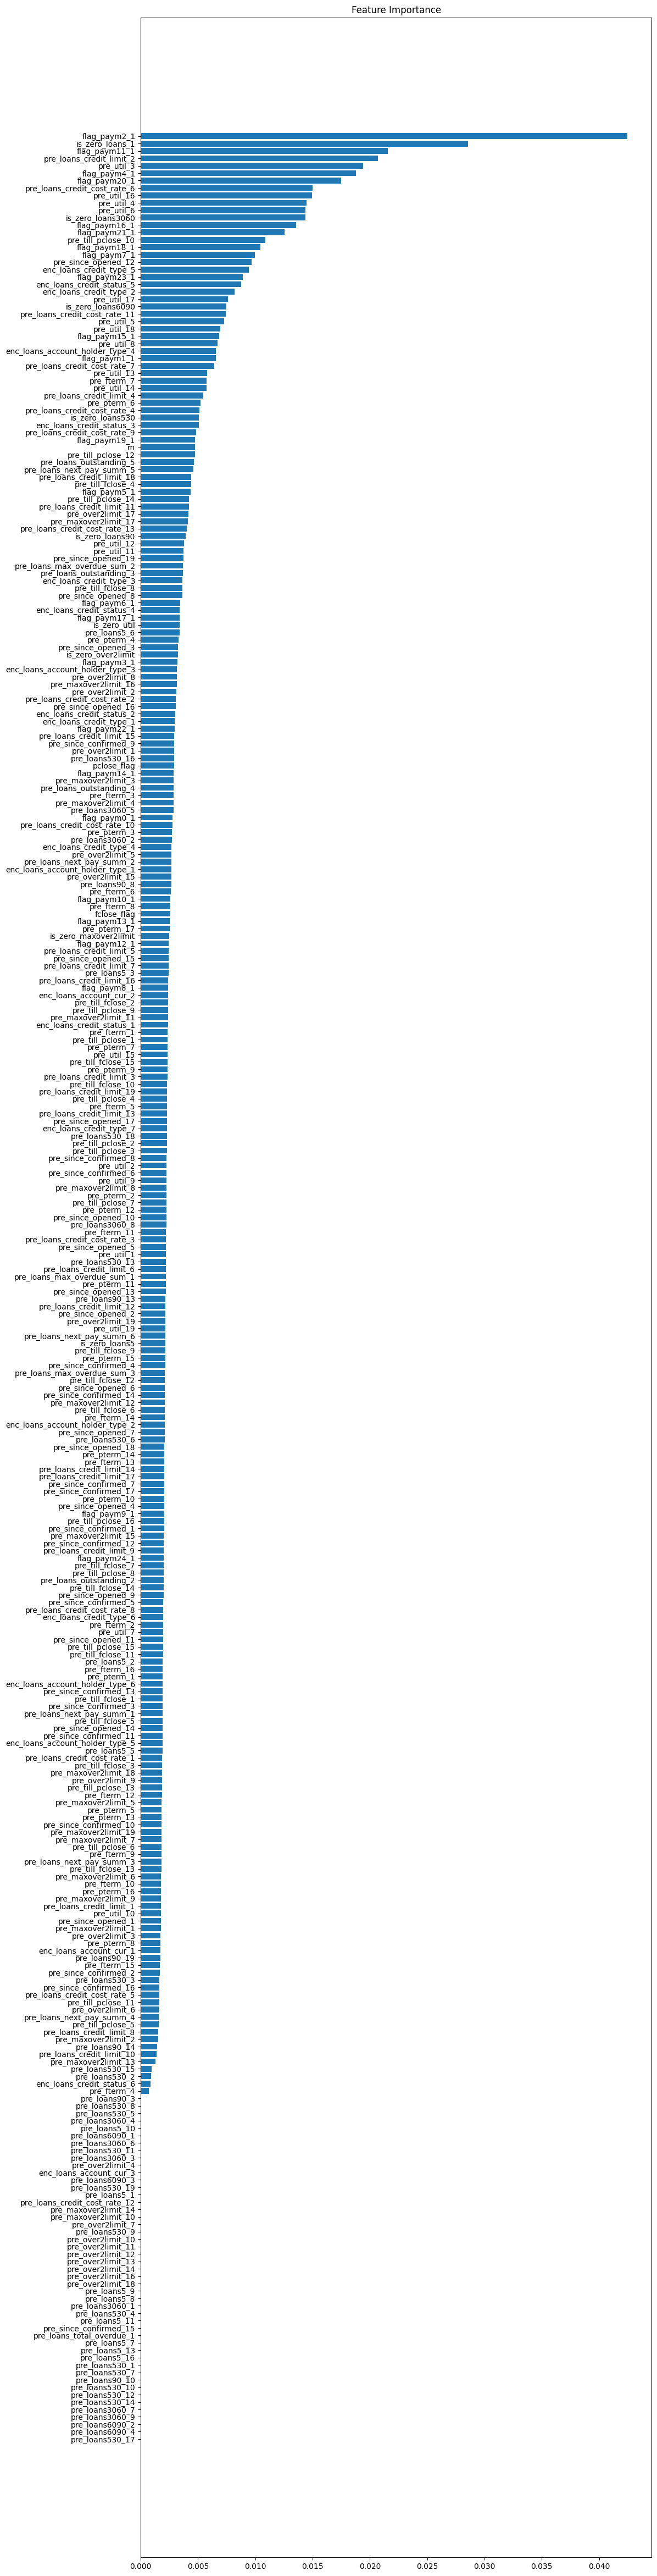

In [33]:
#Наиболее важные признаки модели
feature_importance = xgboost.feature_importances_
pd.Series(feature_importance, index=X_test.columns).sort_values()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 60))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [34]:
# LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

pred_train_lgbm = lgbm.predict_proba(X_train)
pred_test_lgbm = lgbm.predict_proba(X_test)




print('lgbm на тренировочном датасете:',roc_auc_score(y_train, pred_train_lgbm[:, 1]), roc_auc_score(y_test, pred_test_lgbm[:, 1]))

[LightGBM] [Info] Number of positive: 85125, number of negative: 2314875
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.009570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31007
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035469 -> initscore=-3.302990
[LightGBM] [Info] Start training from score -3.302990
lgbm на тренировочном датасете: 0.7651905944550816 0.7544966695635666


In [35]:
# LGBMClassifier с балансировкой класса

lgbm = LGBMClassifier(class_weight = 'balanced')
lgbm.fit(X_train, y_train)

pred_train_lgbm = lgbm.predict_proba(X_train)
pred_test_lgbm = lgbm.predict_proba(X_test)



# Оценка производительности модели
print('lgbm на тренировочном датасете:',roc_auc_score(y_train, pred_train_lgbm[:, 1]), roc_auc_score(y_test, pred_test_lgbm[:, 1]))

[LightGBM] [Info] Number of positive: 85125, number of negative: 2314875
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.234168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31007
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
lgbm на тренировочном датасете: 0.7645600494014998 0.7552232604638386


In [36]:
#catboost
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=4)
catboost.fit(X_train, y_train)

# Оценка производительности модели
catboost_pred = catboost.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, catboost_pred)
print(f"ROC AUC Score: {roc_auc}")

0:	learn: 0.5534021	total: 1.23s	remaining: 20m 27s
1:	learn: 0.4475170	total: 2.78s	remaining: 23m 6s
2:	learn: 0.3706471	total: 3.97s	remaining: 21m 58s
3:	learn: 0.3143261	total: 5.64s	remaining: 23m 23s
4:	learn: 0.2725502	total: 7.28s	remaining: 24m 9s
5:	learn: 0.2421339	total: 8.67s	remaining: 23m 56s
6:	learn: 0.2195123	total: 10.4s	remaining: 24m 32s
7:	learn: 0.2032919	total: 12.1s	remaining: 24m 55s
8:	learn: 0.1902824	total: 13.4s	remaining: 24m 38s
9:	learn: 0.1803012	total: 15s	remaining: 24m 40s
10:	learn: 0.1727827	total: 16.3s	remaining: 24m 28s
11:	learn: 0.1668932	total: 17.8s	remaining: 24m 22s
12:	learn: 0.1621947	total: 19.1s	remaining: 24m 8s
13:	learn: 0.1587140	total: 20.4s	remaining: 23m 54s
14:	learn: 0.1557902	total: 21.7s	remaining: 23m 46s
15:	learn: 0.1534126	total: 23.4s	remaining: 23m 56s
16:	learn: 0.1515209	total: 24.9s	remaining: 24m 2s
17:	learn: 0.1499750	total: 26.6s	remaining: 24m 12s
18:	learn: 0.1487452	total: 28.1s	remaining: 24m 11s
19:	learn

Наилучшей моделью оказалась LGBMClassifier, подберем гиперпараметры модели

In [38]:
estimator=LGBMClassifier(random_state=42)

params = {
        'n_estimators': [300, 400, 500, 600, 700],
        'num_leaves': (60,100,10),
        'class_weight' : ['balanced']
        }

lgb = GridSearchCV(
    estimator, 
    params,
    cv=3, scoring='roc_auc', verbose=0, n_jobs=-1)

lgb.fit(X_train, y_train)



[LightGBM] [Info] Number of positive: 56750, number of negative: 1543250
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.767631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31079
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 56750, number of negative: 1543250
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.990035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30998
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 299
[Light

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'n_estimators': [300, 400, 500, 600, 700],
                         'num_leaves': (60, 100, 10)},
             scoring='roc_auc')

In [39]:
#результаты моделирования с подобранными гиперпараметрами
print(lgb.best_estimator_)
lgbm = lgb.best_estimator_
lgbm.fit(X_train, y_train)

pred_train_lgbm = lgbm.predict_proba(X_train)
pred_test_lgbm = lgbm.predict_proba(X_test)




print('lgbm на тренировочном датасете:',roc_auc_score(y_train, pred_train_lgbm[:, 1]), roc_auc_score(y_test, pred_test_lgbm[:, 1]))

LGBMClassifier(class_weight='balanced', n_estimators=700, num_leaves=10,
               random_state=42)
[LightGBM] [Info] Number of positive: 85125, number of negative: 2314875
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.344568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30990
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
lgbm на тренировочном датасете: 0.7764310587478559 0.7574945657629634


In [37]:
#результаты моделирования с подобранными гиперпараметрами
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

lgbm = LGBMClassifier(class_weight='balanced', n_estimators=700, num_leaves=10, random_state=42)
lgbm.fit(X_train, y_train)

pred_train_lgbm = lgbm.predict_proba(X_train)
pred_test_lgbm = lgbm.predict_proba(X_test)




print('lgbm на тренировочном датасете:',roc_auc_score(y_train, pred_train_lgbm[:, 1]), roc_auc_score(y_test, pred_test_lgbm[:, 1]))

[LightGBM] [Info] Number of positive: 85125, number of negative: 2314875
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.571844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30990
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
lgbm на тренировочном датасете: 0.7764310587478559 0.7574945657629634


LGBMClassifier(class_weight='balanced', n_estimators=700, num_leaves=10,
               random_state=42)